In [127]:
import os
import h5py
import math
import gc
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
gc.collect()
torch.cuda.empty_cache()

RANDOM_SEED = 42

# 固定隨機性
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

In [129]:
def load_dataset() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    with h5py.File('./datasets/signs.h5', 'r') as f:
        images = np.array(f["images"][:])
        labels = np.array(f["labels"][:])
        classes = np.array(list(set(labels)))

    # train and test set
    train_imgs = images[:-120]
    train_labels = labels[:-120]
    test_imgs = images[-120:]
    test_labels = labels[-120:]

    return train_imgs, train_labels, test_imgs, test_labels, classes

In [130]:
def plot_images(images: np.ndarray, labels: np.ndarray) -> None:
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    n = min(10, images.shape[0])
    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].set_title(labels[i])
        axes[i].axis("off")
    fig.tight_layout()
    # print("labels: ", labels[:n])

In [131]:
train_imgs, train_labels, test_imgs, test_labels, classes = load_dataset()

train_x = train_imgs/255
test_x = test_imgs/255

train_x = train_x.transpose(0, 3, 1, 2)
test_x = test_x.transpose(0, 3, 1, 2)

# train_y = np.eye(len(classes))[train_labels.reshape(-1)]
# test_y = np.eye(len(classes))[test_labels.reshape(-1)]
train_y = train_labels
test_y = test_labels

print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))

train_x shape: (1080, 3, 64, 64)
train_y shape: (1080,)
test_x shape: (120, 3, 64, 64)
test_y shape: (120,)


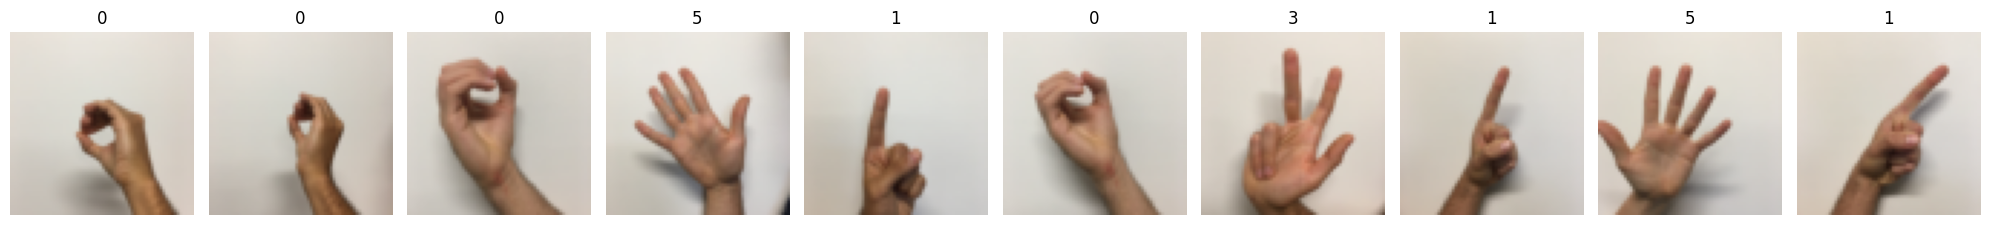

In [132]:
plot_images(test_imgs, test_labels)

# **IDENTITY BLOCK**
A block of layers with skip connection, where the input activation (say *a[i]*) has the same dimension as the output activation (say *a[i+n]* where n is number of layers in the block) is an identity block in a ResNet.
The skip-connection or shortcut is reffered to the path 1 in the figure. While path 2 is the main path.

**Structure of our identity block**

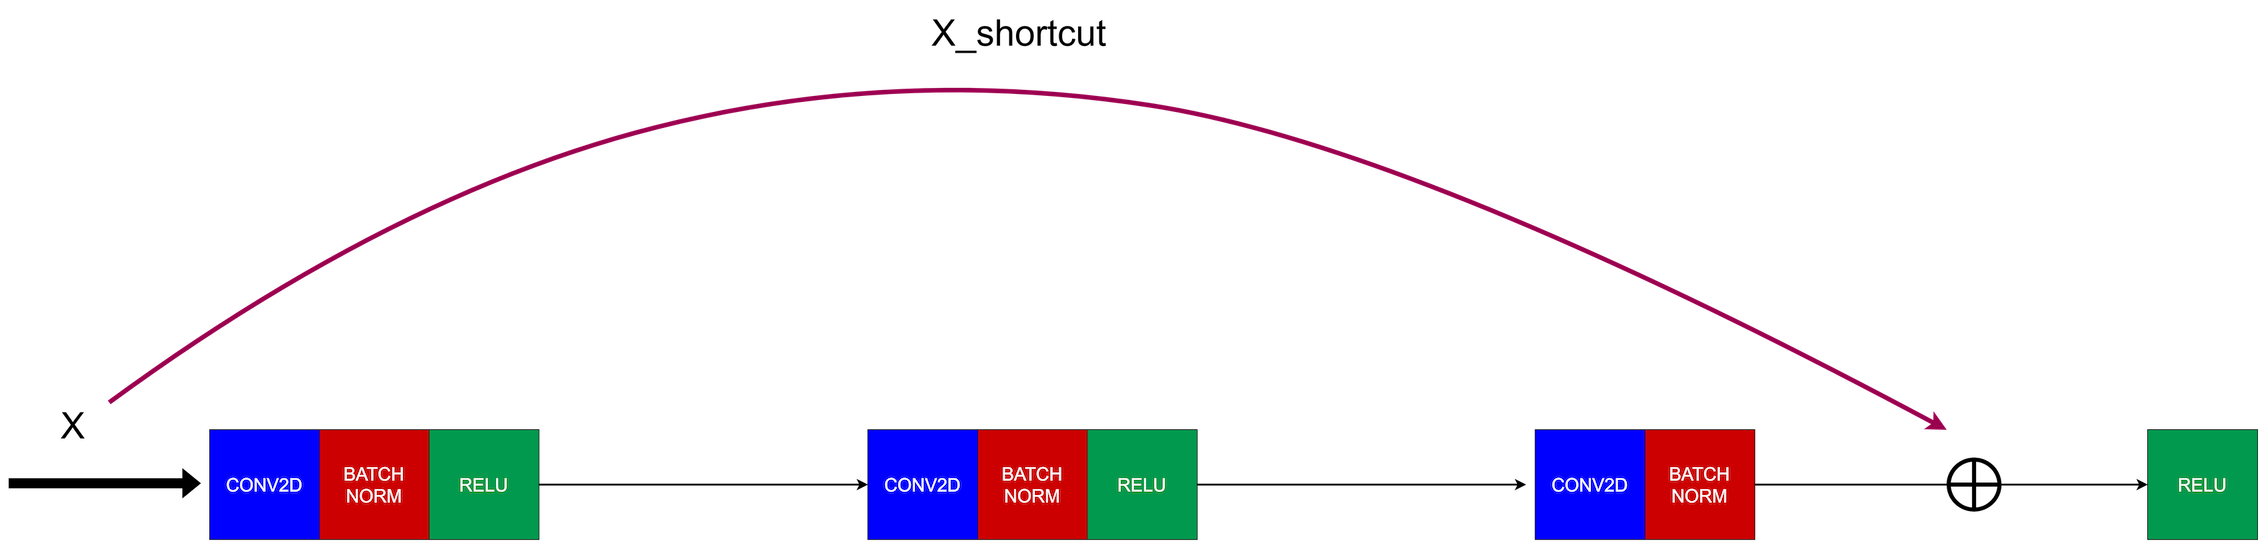

In [133]:
class IdentityBlock(nn.Module):
    def __init__(self, in_channels: int, filters: tuple[int, int, int], f: int) -> None:
        '''
        Implementation of identity block described above

        Arguments:
        in_channels - input tensor to the block of shape (N, C, H, W)
        filters     - list of integers, defining the number of filters in each layer of the main path
        f           - defines shpae of filter in the middle layer of the main path

        Returns: 
        X - output is a tensor of shape (C, H, W) which matches (N, C, H, W)
        '''
        super(IdentityBlock, self).__init__()
        f1, f2, f3 = filters

        self.conv1 = nn.Conv2d(in_channels, f1, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(f1)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(f1, f2, kernel_size=f, stride=1, padding=f//2)
        self.bn2 = nn.BatchNorm2d(f2)

        self.conv3 = nn.Conv2d(f2, f3, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(f3)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_skip_connection = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        x += x_skip_connection
        x = self.relu(x)

        return x

# **CONVOLUTIONAL** **BLOCK**

This is another kind of block with skip-connection in the ResNet. In this the input to block, and output of last layer in the block don't match in dimensions. So we need to add a convolution step in the skip-connection, before adding the input to last layer's output. This convolution step changes the dimension of the input, so that the dimensions match up for the later addition step.

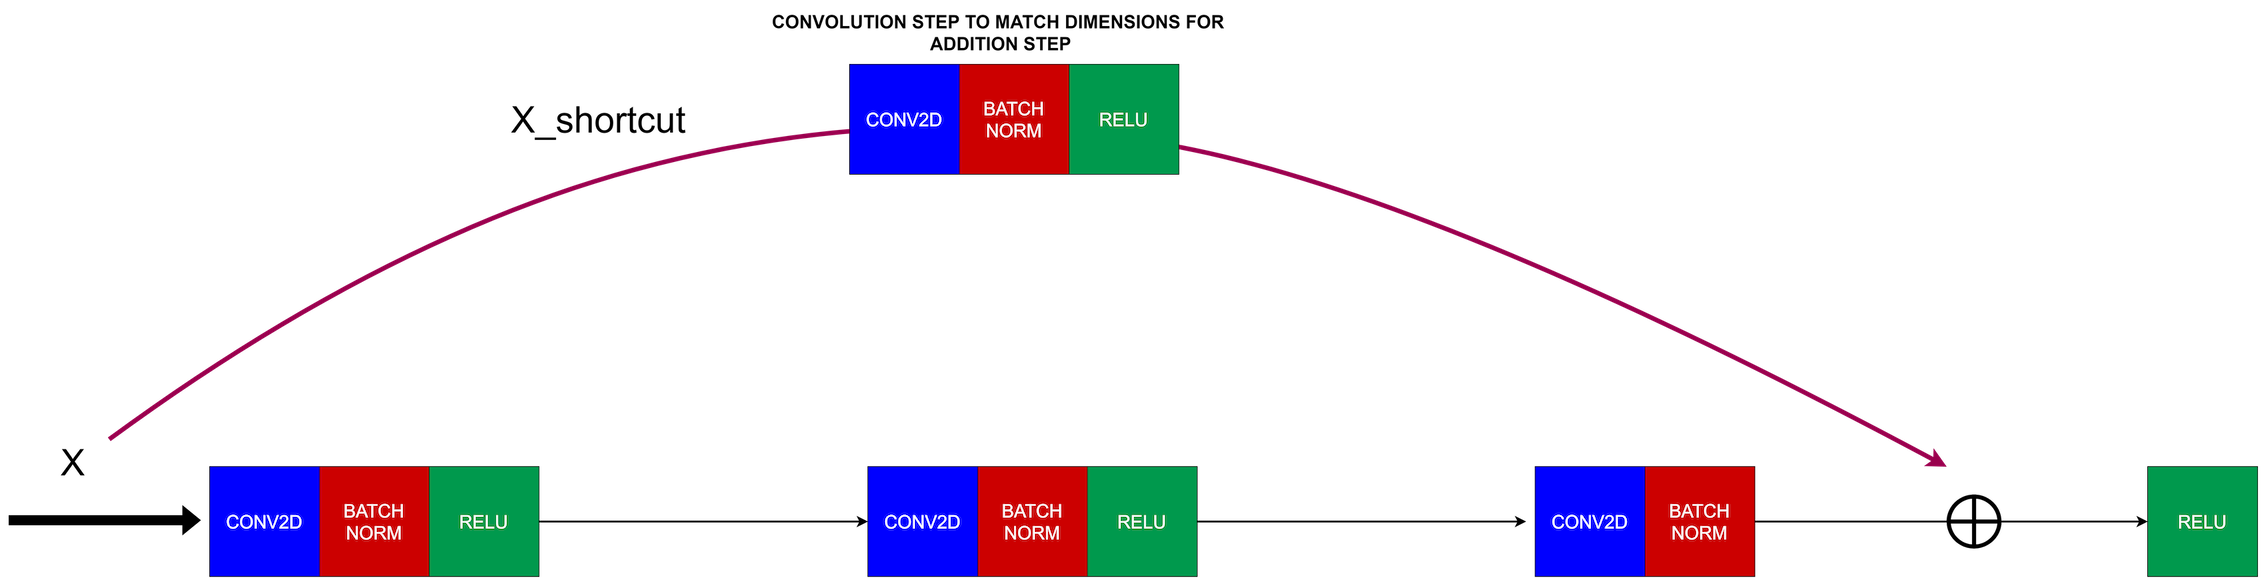

In [134]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels: int, filters: tuple[int, int, int], f: int) -> None:
        '''
        Implementation of convolutional block described above

        Arguments:
        in_channels - input tensor to the block of shape (N, C, H, W)
        filters     - list of integers, defining the number of filters in each layer of the main path
        f           - defines shpae of filter in the middle layer of the main path

        Returns: 
        X - output is a tensor of shape (N, C, H, W)
        '''
        super(ConvolutionalBlock, self).__init__()
        f1, f2, f3 = filters

        self.conv1 = nn.Conv2d(in_channels, f1, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(f1)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(f1, f2, kernel_size=f, stride=1, padding=f//2)
        self.bn2 = nn.BatchNorm2d(f2)
        
        self.conv3 = nn.Conv2d(f2, f3, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(f3)

        self.shortcut_conv = nn.Conv2d(in_channels, f3, kernel_size=1, stride=1, padding=0)
        self.shortcut_bn = nn.BatchNorm2d(f3)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_skip_connection = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        x_skip_connection = self.shortcut_conv(x_skip_connection)
        x_skip_connection = self.shortcut_bn(x_skip_connection)

        x += x_skip_connection
        x = self.relu(x)

        return x

# **RESNET50** 
Now that we have our building blocks - Convolutional block and identity block in place, we will build a 50 layer deep neural network with skip connections that implements the follwoing architecture 

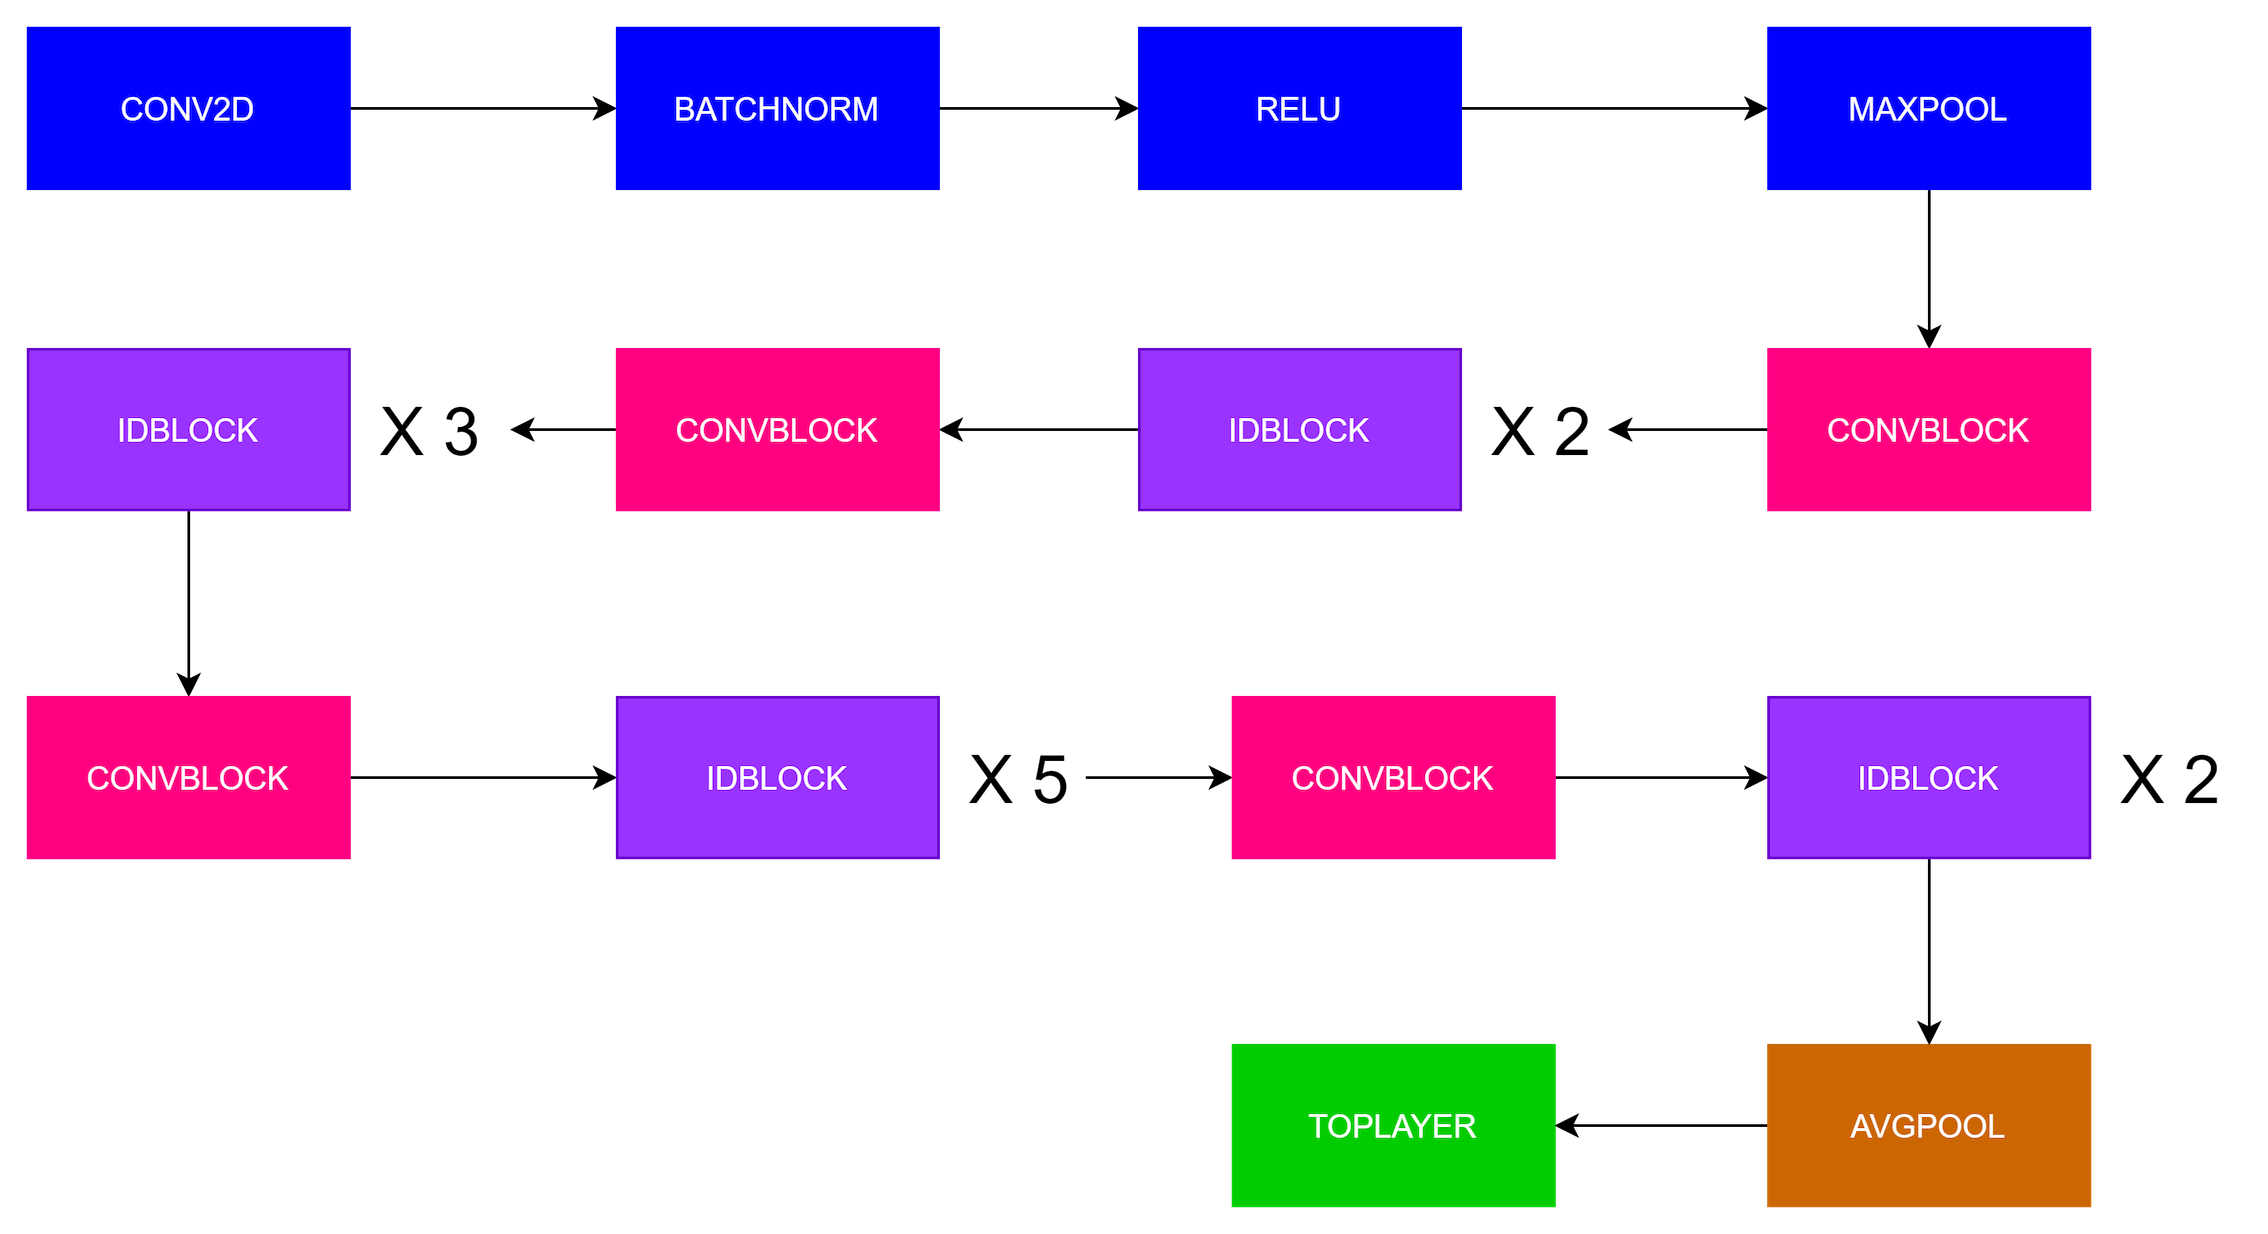

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, classes: int, in_channels: int, device: torch.device = torch.device("cpu")) -> None:
        """
        Arguments:
        input_shape - shape of the images of the dataset
        classes     - number of classes
        device      - device to run the model on (e.g., "cpu" or "cuda")
        Returns:    
        model - a Model() instance in PyTorch
        """
        super(ResNet50, self).__init__()
        self.device = device

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=7//2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=3//2)

        # self.layer1 = self._make_layer(64, (64, 64, 256), 3, f=3)
        # self.layer2 = self._make_layer(256, (128, 128, 512), 4, f=3)
        # self.layer3 = self._make_layer(512, (256, 256, 1024), 6, f=3)
        # self.layer4 = self._make_layer(1024, (512, 512, 2048), 3, f=3)
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.layer1 = self._make_layer(64, (64, 64, 256), 3, f=3)
        self.layer2 = self._make_layer(256, (64, 64, 256), 3, f=3)
        self.layer3 = self._make_layer(256, (64, 64, 256), 3, f=3)
        self.layer4 = self._make_layer(256, (64, 64, 128), 3, f=3)
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc = nn.Linear(2048, classes)

    def _make_layer(self, in_channels: int, filters: tuple[int, int, int], blocks: int, f: int) -> nn.Sequential:
        layers = []
        layers.append(ConvolutionalBlock(in_channels, filters, f))
        for _ in range(1, blocks):
            layers.append(IdentityBlock(filters[-1], filters, f))
        return nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Training

In [136]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, transform=None) -> None:
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [137]:


def train(model: nn.Module, train_loader: torch.utils.data.DataLoader, lr: float, criterion: nn.Module, optimizer: torch.optim.Optimizer, progress_title: str = "Epoch") -> float:
    model.train()
    total_loss = 0.0
    loop = tqdm(train_loader, desc=progress_title)
    for inputs, labels in loop:
        inputs = inputs.to(model.device, dtype=torch.float32)
        labels = labels.to(model.device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        loop.set_postfix(loss=f"{loss.item():.4f}", avg_loss=f"{total_loss / (loop.n + 1):.4f}")

    return total_loss / (loop.n + 1)

def eval(model: nn.Module, test_loader: torch.utils.data.DataLoader, progress_title: str = "Eval") -> None:
    model.eval()
    true_list = np.array([])
    pred_list = np.array([])
    with torch.no_grad():
        loop = tqdm(test_loader, desc=progress_title)
        for inputs, labels in loop:
            inputs = inputs.to(model.device, dtype=torch.float32)
            
            outputs = model(inputs)
            true_list = np.append(true_list, labels)
            pred_list = np.append(pred_list, torch.argmax(outputs, dim=-1).cpu().numpy())

            accuracy = float(accuracy_score(true_list, pred_list))
            precision = float(precision_score(true_list, pred_list, average='weighted', zero_division=0))
            recall = float(recall_score(true_list, pred_list, average='weighted', zero_division=0))
            f1 = float(f1_score(true_list, pred_list, average='weighted', zero_division=0))
            loop.set_postfix(f1=f"{f1:.4f}", acc=f"{accuracy:.4f}", precision=f"{precision:.4f}", recall=f"{recall:.4f}")


In [ ]:
train_data = Dataset(train_x, train_y)
test_data = Dataset(test_x, test_y)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(RANDOM_SEED))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)


model = ResNet50(classes=len(classes), in_channels=3, device=device).to(device)

epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(
    f"Epochs: {epochs}\n"
    f"Learning rate: {learning_rate}\n"
    f"Using device: {device}\n"
)
for epoch in range(epochs):
    train(model, train_loader, learning_rate, criterion, optimizer, progress_title=f"Epoch {epoch + 1}/{epochs}")
    # eval(model, test_loader, progress_title=f"Evaluating {epoch + 1}/{epochs}")
eval(model, test_loader, progress_title=f"Eval")

Epochs: 10
Learning rate: 0.001
Using device: mps



Eval: 100%|██████████| 4/4 [00:00<00:00, 54.29it/s, acc=0.9167, f1=0.9157, precision=0.9241, recall=0.9167]


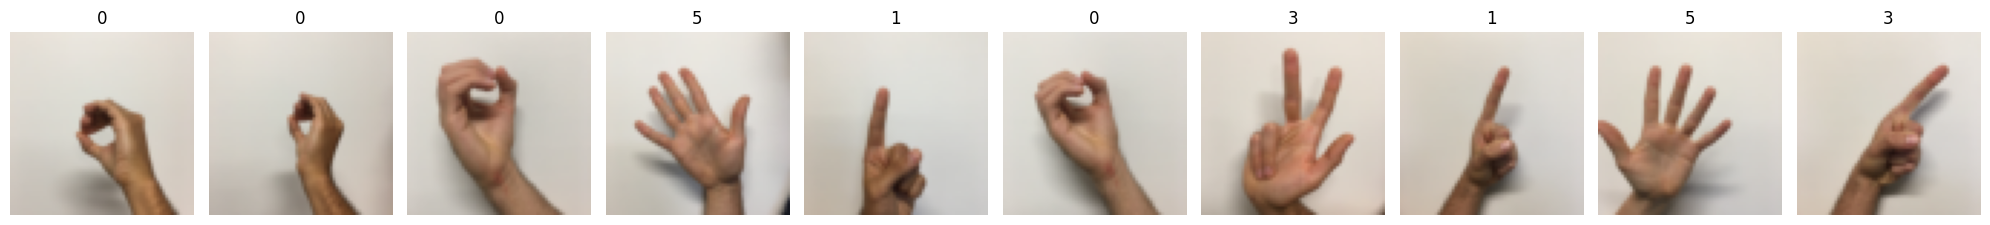

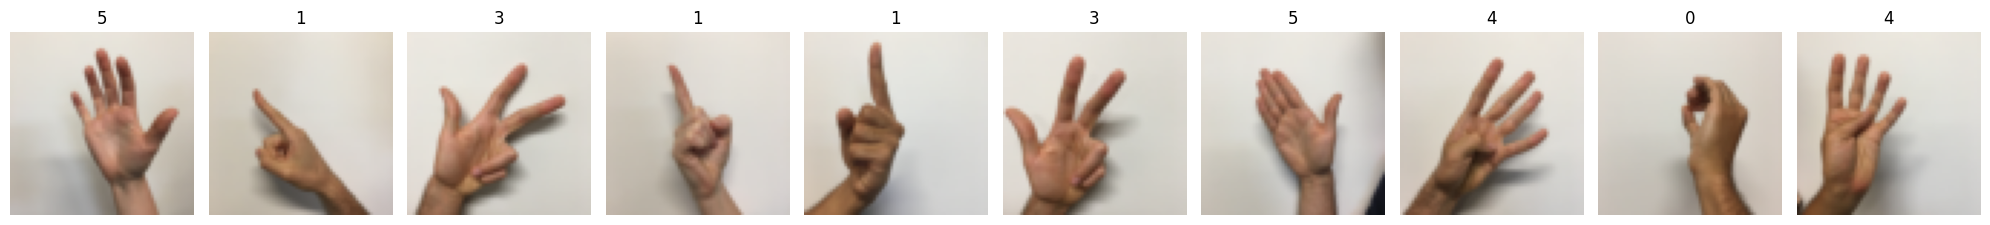

In [139]:
prods = model(torch.tensor(test_x[:20], dtype=torch.float32).to(device))
pred_labels = torch.argmax(prods, dim=-1).cpu().numpy()
plot_images(test_imgs[:10], pred_labels[:10])
plot_images(test_imgs[10:20], pred_labels[10:20])

In [140]:
del model
gc.collect()
torch.cuda.empty_cache()